In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from scipy.special import erf


%matplotlib inline

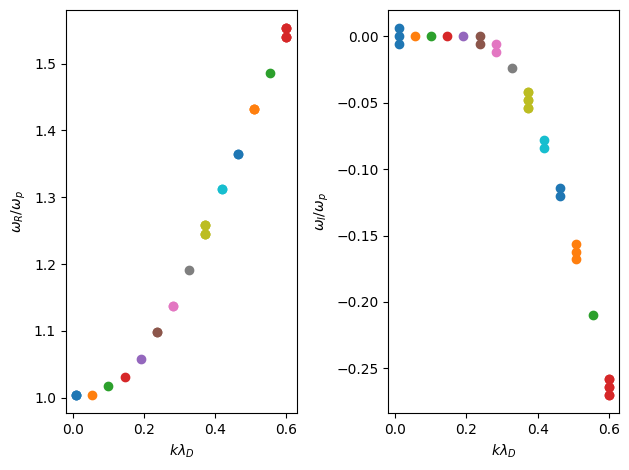

In [21]:
def dfMdv(v):
    return 1./np.sqrt(2*np.pi) * (-v) * np.exp(-0.5*v**2)

def dfBOTdv(v, v0, nb):
    return (1-nb)*dfMdv(v) + 0.5*nb*(dfMdv(v-v0)) + 0.5*nb*(dfMdv(v+v0))

def D_analytic(wr, wi, k0, v0, nb):
    vphi = wr/k0
    eps_v = 1e-3
    v = np.linspace(-12, vphi-eps_v,2048)
    integral = np.trapz(dfBOTdv(v, v0, nb) / (v-(wr+1j*wi)/k0), v)
    v = np.linspace(vphi+eps_v,12, 2048)
    integral += np.trapz(dfBOTdv(v, v0, nb) / (v-(wr+1j*wi)/k0), v)
    d = 1.-1./(k0**2) *integral
    # deforming contour under pole
    if wi == 0:
        d -= 1j*np.pi/k0**2 * dfBOTdv((wr+1j*wi)/k0, v0, nb)
    elif wi<0:
        d -= 2j*np.pi/k0**2 * dfBOTdv((wr+1j*wi)/k0, v0, nb)
    return d

def find_w_roots(k0, v0, nb):
    Wr = np.linspace(0,1.7,128)
    Wi = np.linspace(-0.3,0.3,101)

    D_arr = np.zeros((len(Wi), len(Wr)), dtype = complex)
    for i in range(len(Wi)):
        for j in range(len(Wr)):
            D_arr[i,j] = D_analytic(Wr[j], Wi[i], k0=k0, v0 = v0, nb = nb)
    
    D_arr = np.abs(D_arr)
    zeros = np.where(D_arr<2*D_arr.min())
    return Wr[zeros[1]][:], Wi[zeros[0]][:]
    
# print(find_w_roots(k0=0.3))

ax1 = plt.subplot(1,2,1)
ax1.set_xlabel(r'$k\lambda_D$')
ax1.set_ylabel(r'$\omega_R/\omega_p$')
ax2 = plt.subplot(1,2,2)
ax2.set_xlabel(r'$k\lambda_D$')
ax2.set_ylabel(r'$\omega_I/\omega_p$')

k0s = np.linspace(0.01,0.6,14)

v0 = 4
nb = 0
for k0 in k0s:
    Wrs, Wis = find_w_roots(k0, v0, nb )
    ax1.scatter(k0*np.ones(len(Wrs)), Wrs)
    ax2.scatter(k0*np.ones(len(Wis)), Wis)

plt.tight_layout()



Awesome. Amazing. Beautiful. Now let's compare this with the analytical solutions to the dispersion relation(s) that we found in class.

Bohm-Gross dispersion function is: $\frac{\omega^2}{\omega_p^2} = 1 + \frac{3 v_{th}^2 k^2}{\omega_p^2} = 1 + 3 \lambda_d^2 k^2$

Let's plot this over the dispersion relation we found numerically

In [22]:
def bohm_gross(lambda_k):
    return np.sqrt(1 + 3*lambda_k**2)

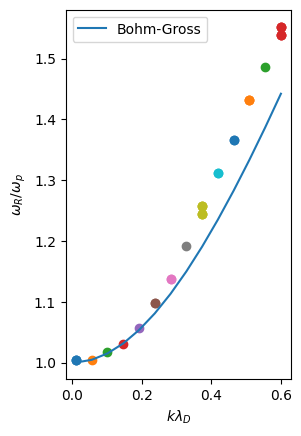

In [23]:
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel(r'$k\lambda_D$')
ax1.set_ylabel(r'$\omega_R/\omega_p$')

k0s = np.linspace(0.01,0.6,14)

for k0 in k0s:
    Wrs, Wis = find_w_roots(k0, v0 = 4, nb = 0)
    ax1.scatter(k0*np.ones(len(Wrs)), Wrs)  # There is a better way to graph all of these data points as one plt.scatter function 
                                            # call and that way you will be able to label them as numerical but I am TOO LAZY
                                            # to figure it out!!!!                    

plt.plot(k0s,bohm_gross(k0s), label = 'Bohm-Gross')

plt.legend()
plt.show()

Great! As would be expected, they give similar results at low values of k and diverge as k grows.

The next step would be to include the first order correction for landau damping.

The corrected dispersion relation is:
$\omega = \omega_{BG}+ i \omega_i$

Where $\omega_i = \frac{\pi}{2} \omega_{bg} \frac{\omega_{bg}^2}{k^2} \frac{1}{n_0} \frac{\partial f_{e0}}{\partial v}$ evaluated at $\frac{\omega_{bg}}{k}$

Wait actually I think that I need to divide the $\frac{\partial f_{e0}}{\partial v}$ term by $v_{th}^2$ or something. Using guess and check, a factor of 1/2 seems to be very close. Mychal and Rayner please try to figure out where I am missing this factor.



In [34]:
def omega_i_correction(k, v0 = v0, nb = nb):
    return np.pi/2 * bohm_gross(k)**3/k**2 * 1/2*dfBOTdv(bohm_gross(k)/k,v0,nb) # I think that I don't need to include 1/n0
                                                                            # but please check my work. I did this pretty
                                                                            # quickly

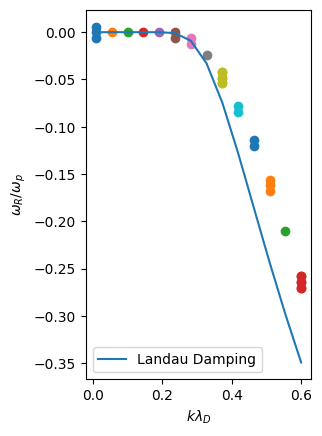

In [35]:
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel(r'$k\lambda_D$')
ax1.set_ylabel(r'$\omega_R/\omega_p$')

k0s = np.linspace(0.01,0.6,14)

for k0 in k0s:
    Wrs, Wis = find_w_roots(k0, v0 = 4, nb = 0)
    ax1.scatter(k0*np.ones(len(Wis)), Wis)  # There is, again, a better way. But, again, too lazy.
                    

plt.plot(k0s,omega_i_correction(k0s), label = 'Landau Damping corrected by 1/2')

plt.legend()
plt.show()

Hm. Doesn't look great. If you guys can check my work and make sure that it is right, that's probably a good idea.

Next steps:

0) Check all of my work
1) Quantify the error of the numerical results and the two different plots we created
2) Include ions in this analysis
3) Create input file so we can run some Osiris simulations